In [ ]:
! pip install graphviz

In [ ]:
! pip install pydot

In [ ]:
! pip install WordCloud

In [65]:
import numpy as np
from scipy.special import gammaln
import random
from collections import Counter
import pickle
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pickle
import graphviz
import pydot
import pygraphviz

In [ ]:
import numpy as np
from scipy.special import gammaln
import random
from collections import Counter
import pickle
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pickle
import graphviz
import pydot
import pygraphviz

def CRP_next(lambdas,topic):
    """
    Description
    ---------
    Funcion: Chinese Restaurant Process
    
    Parameter
    ---------
    alpha: concentration parameter 
    topic: the exist tables 
    
    Return
    ------
    p: the probability for a new customers to sit in each of the tables
    """
    import numpy as np
    N=len(topic) # number of tables
    word_list=[] # total customers
    for t in topic:
        word_list=word_list+t
    m=len(word_list) # customers' number
    
    tables = np.array([len(x) for x in topic])  # tables with their customers
    p_old=tables/(lambdas+m) # the probability of sitting in a table with other people   
    p_new=lambdas/(lambdas+m)      # the probability of sitting in a new table
    p=[p_new]+list(p_old)  # the last probability is the probability to sit in a new table 
    return(p)


def topics(corpus,lambdas):
    topic=[]
    for docs in corpus:
        for word in docs:
            p=CRP_next(lambdas,topic)
            position=np.random.multinomial(1, list((np.array(p)/sum(p))))
            position=int(np.where(position!=0)[0])
            if position==0:
                topic.append([word])
            else:
                topic[position-1].append(word)
    return(topic)


def Z(corpus, T, alpha, beta):
    """
    Description
    ---------
    Funcion:  sample zmn under LDA model
    
    Parameter
    ---------
    corpus: the total corpus, a list of documents, that is, a list of lists
    T: the number of topics
    alpha, beta: parameters
    
    Return
    ------
    topic: the word list in each topic
    topic_num: the length of each topic
    """
    import numpy as np
    W=np.sum([len(word) for word in corpus]) # the number of the total words
    N=len(corpus)                            # the number of documents 
    topic=[[] for t in range(T)]
    topic_num=[[] for t in range(T)]
    for i,di in enumerate(corpus):
        for wi in di:
            p=np.zeros(T)
            for j in range(T):
                nij_wi=topic[j].count(wi)   # number of wi tht assigned to topic j
                nij=len(topic[j])           # total number of words assigned to topic j 
                nij_di=np.sum(np.isin(topic[j],di)) # number of words from di in topic j
                ni_di=len(di)               # total number of words in di
                part1=(nij_wi+beta)/(nij+W*beta)
                part2=(nij_di+alpha)/(ni_di+T*alpha)
                p[j]=part1 * part2
            pp=p/np.sum(p)
            w_assign=np.random.multinomial(1, pp, size=1)
            i_topic=int(np.where(w_assign[0]==1)[0])
            topic[i_topic].append(wi)
            topic_num[i_topic].append(i)
    return(topic,topic_num)

def CRP_prior(corpus,topic,lambdas):
    res=np.zeros((len(corpus),len(topic)))
    for i,docs in enumerate(corpus):
        p_topic=[]
        for j in range(len(topic)):
            temp=[]
            for x in topic[j]:
                if x != i:
                    temp.append(x)
            p_topic.append(temp)
        temp=CRP_next(lambdas,p_topic)
        res[i,:]=temp[1:]   
    return(res)


def word_likelihood(corpus,topic,eta):

    import math
    import numpy as np
    from scipy.special import gammaln

    res=np.zeros((len(corpus),len(topic)))  # generate the results matrix
    
    word_list=[]                            # generate the word list that contains all the words
    for i in range(len(corpus)):
        word_list=word_list+corpus[i]
    W=len(word_list)                        # the length of word list
    
    for i,di in enumerate(corpus):
        p_w=0
        for j in range(len(topic)):         #calculate the tow parts of the equation
            nc_dot=len(topic[j])    
            part1_denominator=1
            part2_nominator=1
            
            overlap=len(set(topic[j]))-len(set(topic[j])-set(di))
            
            part1_nominator = gammaln(nc_dot-overlap+W*eta)
            part2_denominator = gammaln(nc_dot+W*eta)
        
            for word in di:
                ncm_w=topic[j].count(word)-di.count(word)
                if ncm_w <0:
                    ncm_w=0
                nc_w=topic[j].count(word)
                part1_denominator=part1_denominator+gammaln(ncm_w+eta)
                part2_nominator=part2_nominator+gammaln(nc_w+eta)
           
            p_w=part1_nominator-part1_denominator+part2_nominator-part2_denominator 
            res[i,j]=p_w
        res[i, :] = res[i, :] + abs(min(res[i, :]) + 0.1)
    res=res/np.sum(res,axis=1).reshape(-1,1)
    return(res)


def hierarchical_LDA(corpus, alpha, beta, lambdas, eta, iters, level,num=5):
    
    from collections import Counter
    import numpy as np
    
    topic = topics(corpus, lambdas)    
    node = [[] for _ in range(level)]
    node_num = [[] for _ in range(level+1)]
    node_num[0].append(1)
    
    print("*********level %d***********" % 0)
    word_topic = nodes(corpus, len(topic), alpha, beta, lambdas, eta, iters)
    words = sum(word_topic[0],[])
    node[0].append(words)
    print_word=list(dict(Counter(words).most_common(num)).keys())
    print('  >>level',0,'node 1:',print_word)
    temp=word_topic[1:]
    node_num[1].append(len(word_topic[1:]))
    
    for i in range(1,level):
        print(' ')
        print("*********level %d***********" % i)
        for j in range(sum(node_num[i])):
            if len(temp)<1:
                break
            word_topic2 = nodes(temp[0], len(topic), alpha, lambdas, eta, iters)
            words2 = sum(word_topic2[0],[])
            node[i].append(words2)
            print_word2=list(dict(Counter(words2).most_common(num)).keys())
            print('  >>level',i,'node',j+1,":",print_word2)
            temp=temp[1:]
            if len(word_topic2)>2:
                temp.extend(word_topic2[1:])
            node_num[i+1].append(len(word_topic2[1:]))
    print(' ')
    print("Summary")
    print('Total level = ',level)
    print('Topic number = ',len(topic))
    print('Each level contains nodes:',node_num[:level])
    return(node,node_num[:level])


def tree_plot(hlda,num=5):
    
    from IPython.display import Image, display
    import matplotlib.pyplot as plt
    from collections import Counter
    
    w=hlda[0]
    s=hlda[1]
    graph = pydot.Dot(graph_type='graph')
    for i in range(1,len(s)):
        n1=s[i] # 10
        w1=w[i]
        start=0
        for j in range(len(n1)):
            val=w[i-1][j]
            val=list(dict(Counter(val).most_common(num)).keys())
            root='\n'.join(val)
            n2=n1[j] #8
            end=start+n2
            w2=w1[start:end]
            for k in range(n2):
                w3=w2[k]
                val2=list(dict(Counter(w3).most_common(num)).keys())
                leaf='\n'.join(val2)
                edge = pydot.Edge(root, leaf)
                graph.add_edge(edge)
            start=end
    plt = Image(graph.create_png())
    display(plt)

codes:

read in an example

to show each step's function, we read in some data as our examples



In [66]:
docs=pickle.load(open('pubmed.pic', 'rb'))
docslist=[]
docs_list=list(docs)
for j in range(10):
    corpus=[]
    for i in range(10):
        corpus=corpus+[docs_list[i+j*10]]
    docslist.append(str(corpus))
corpus=[x.split(" ")  for x in docslist]

corpus1=corpus

a simple example made by ourselve

In [67]:
corpus2=[['a'],['b','c','d'],['e','f','a','c'],['g','d','e','b','a']]

CRP

In [68]:
def CRP_next(lambdas,topic):
    """
    Description
    ---------
    Funcion: Chinese Restaurant Process
    
    Parameter
    ---------
    alpha: concentration parameter 
    topic: the exist tables 
    
    Return
    ------
    p: the probability for a new customers to sit in each of the tables
    """
    import numpy as np
    N=len(topic) # number of tables
    word_list=[] # total customers
    for t in topic:
        word_list=word_list+t
    m=len(word_list) # customers' number
    
    tables = np.array([len(x) for x in topic])  # tables with their customers
    p_old=tables/(lambdas+m) # the probability of sitting in a table with other people   
    p_new=lambdas/(lambdas+m)      # the probability of sitting in a new table
    p=[p_new]+list(p_old)  # the last probability is the probability to sit in a new table 
    return(p)

 Example

In [15]:
topic=[['a', 'ggtfdg', 'dsgfgfd', 'ds', 'ds', 'yhhr'], ['123', '66']]
CRP_next(1,topic) # set in the old table 1, old table 2, new table 

[0.1111111111111111, 0.6666666666666666, 0.2222222222222222]

get the topic number of the corpus

In [69]:
def topics(corpus,lambdas):
    topic=[]
    for docs in corpus:
        for word in docs:
            p=CRP_next(lambdas,topic)
            position=np.random.multinomial(1, list((np.array(p)/sum(p))))
            position=int(np.where(position!=0)[0])
            if position==0:
                topic.append([word])
            else:
                topic[position-1].append(word)
    return(topic)

In [22]:
lambdas=4
len(topics(corpus1,lambdas))

23

In [27]:
np.random.seed(2)
topics(corpus2,lambdas)

[['a'], ['b'], ['c'], ['d', 'e', 'f', 'a', 'c', 'g', 'd', 'e', 'b', 'a']]

sample z

In [70]:
def Z(corpus, T, alpha, beta):
    """
    Description
    ---------
    Funcion:  sample zmn under LDA model
    
    Parameter
    ---------
    corpus: the total corpus, a list of documents, that is, a list of lists
    T: the number of topics
    alpha, beta: parameters
    
    Return
    ------
    topic: the word list in each topic
    topic_num: the length of each topic
    """
    import numpy as np
    W=np.sum([len(word) for word in corpus]) # the number of the total words
    N=len(corpus)                            # the number of documents 
    topic=[[] for t in range(T)]
    topic_num=[[] for t in range(T)]
    for i,di in enumerate(corpus):
        for wi in di:
            p=np.zeros(T)
            for j in range(T):
                nij_wi=topic[j].count(wi)   # number of wi tht assigned to topic j
                nij=len(topic[j])           # total number of words assigned to topic j 
                nij_di=np.sum(np.isin(topic[j],di)) # number of words from di in topic j
                ni_di=len(di)               # total number of words in di
                part1=(nij_wi+beta)/(nij+W*beta)
                part2=(nij_di+alpha)/(ni_di+T*alpha)
                p[j]=part1 * part2
            pp=p/np.sum(p)
            w_assign=np.random.multinomial(1, pp, size=1)
            i_topic=int(np.where(w_assign[0]==1)[0])
            topic[i_topic].append(wi)
            topic_num[i_topic].append(i)
    return(topic,topic_num)


def nodes(corpus,T,alpha,beta,lambdas,eta,iters=100):

    word_list=[]
    for x in corpus:
        word_list=word_list+x
    W=len(word_list)
    gibbs=np.zeros((W,iters))
    
    for j in range(iters):
        topic=Z(corpus, T, alpha, beta)[0]
        w_m=word_likelihood(corpus,topic,eta)
        c_=CRP_prior(corpus,topic,lambdas)
        c_m = (w_m * c_) / (w_m * c_).sum(axis = 1).reshape(-1,1)
        
        g=[]
        for i,docs in enumerate(corpus):
            if np.sum(c_m[i,:-1])>1:
                c_m[i,-1]=0
                c_m[i,:-1]=c_m[i,:-1]/np.sum(c_m[i,:-1])
            for word in docs:     
                g.append(int(np.where(np.random.multinomial(1, c_m[i])!=0)[0]))
        gibbs[:,j]=g

    word_topic=[]
    for i in range(W):
        word_topic.append(int(Counter(gibbs[i]).most_common(1)[0][0]))
    n_topic=np.max(word_topic)+1
    
    wn_topic = [[] for _ in range(n_topic)]
    wn_doc_topic = [[] for _ in range(n_topic)]

    n = 0
    for i in range(len(corpus)):
        for word in corpus[i]:
            #print(n)
            wn_doc_topic[word_topic[n]].append(word)
            n=n+1
        for j in range(n_topic):
            if wn_doc_topic[j] != []:
                wn_topic[j].append(wn_doc_topic[j])
        wn_doc_topic = [[] for _ in range(n_topic)]        

    wn_topic = [x for x in wn_topic if x != []]
    
    return(wn_topic) 

In [75]:
T=4
alpha=1
beta=1
topic11, topic12=Z(corpus1, T, alpha, beta)

In [57]:
np.random.seed(2)
T=2
alpha=1
beta=1
topic21, topic22=Z(corpus2, T, alpha, beta)
print(topic21)
print(topic22)

[['b', 'c', 'd', 'c', 'd', 'b'], ['a', 'e', 'f', 'a', 'g', 'e', 'a']]
[[1, 1, 1, 2, 3, 3], [0, 2, 2, 2, 3, 3, 3]]


CRP prior

In [71]:
def CRP_prior(corpus,topic,lambdas):
    res=np.zeros((len(corpus),len(topic)))
    for i,docs in enumerate(corpus):
        p_topic=[]
        for j in range(len(topic)):
            temp=[]
            for x in topic[j]:
                if x != i:
                    temp.append(x)
            p_topic.append(temp)
        temp=CRP_next(lambdas,p_topic)
        res[i,:]=temp[1:]   
    return(res)

In [52]:
lambdas=4
topic=Z(corpus2, T, alpha, beta)[0]
topic

[['d', 'a', 'c', 'g', 'd', 'e', 'b'], ['a', 'b', 'c', 'e', 'f', 'a']]

In [53]:
CRP_prior(corpus2,topic,lambdas)

array([[0.41176471, 0.35294118],
       [0.41176471, 0.35294118],
       [0.41176471, 0.35294118],
       [0.41176471, 0.35294118]])

In [54]:
T=4
topic11, topic12=Z(corpus1, T, alpha, beta)

In [55]:
CRP_prior(corpus,topic12,lambdas)

array([[0.0966744 , 0.71539056, 0.0324826 , 0.15235886],
       [0.09647059, 0.71607843, 0.03372549, 0.15058824],
       [0.09929633, 0.72400313, 0.02971071, 0.14386239],
       [0.10747664, 0.71028037, 0.03582555, 0.14330218],
       [0.11370717, 0.69937695, 0.03582555, 0.14797508],
       [0.10921766, 0.697134  , 0.03795507, 0.15259489],
       [0.11541441, 0.6979086 , 0.03563129, 0.14794733],
       [0.10995185, 0.70224719, 0.03451043, 0.15008026],
       [0.11173184, 0.68954509, 0.03910615, 0.15642458],
       [0.11181102, 0.69055118, 0.03779528, 0.15669291]])

The calculation of the $p(w_m | c, w_{-m},z)$ value based on the likelihood function: 

$$p(w_m | c, w_{-m},z) = \prod_{l=1}^{L} (\frac{\Gamma (n_{c_{m,l,-m}}^{(\cdot)}+W\eta)}{\prod_{\omega} \Gamma (n_{c_{m,l,-m}}^{(\omega)}+\eta)}\frac{\prod_{\omega} \Gamma(n_{c_{m,l,-m}}^{(\omega)}+n_{c_{m,l,m}}^{(\cdot)}+\eta)}{\Gamma(n_{c_{m,l,-m}}^{(\cdot)}+ n_{c_{m,l,m}}^{(\cdot)} + W\eta)})$$

where,

In [72]:
def word_likelihood(corpus,topic,eta):

    import math
    import numpy as np
    from scipy.special import gammaln

    res=np.zeros((len(corpus),len(topic)))  # generate the results matrix
    
    word_list=[]                            # generate the word list that contains all the words
    for i in range(len(corpus)):
        word_list=word_list+corpus[i]
    W=len(word_list)                        # the length of word list
    
    for i,di in enumerate(corpus):
        p_w=0
        for j in range(len(topic)):         #calculate the tow parts of the equation
            nc_dot=len(topic[j])    
            part1_denominator=1
            part2_nominator=1
            
            overlap=len(set(topic[j]))-len(set(topic[j])-set(di))
            
            part1_nominator = gammaln(nc_dot-overlap+W*eta)
            part2_denominator = gammaln(nc_dot+W*eta)
        
            for word in di:
                ncm_w=topic[j].count(word)-di.count(word)
                if ncm_w <0:
                    ncm_w=0
                nc_w=topic[j].count(word)
                part1_denominator=part1_denominator+gammaln(ncm_w+eta)
                part2_nominator=part2_nominator+gammaln(nc_w+eta)
           
            p_w=part1_nominator-part1_denominator+part2_nominator-part2_denominator 
            res[i,j]=p_w
        res[i, :] = res[i, :] + abs(min(res[i, :]) + 0.1)
    res=res/np.sum(res,axis=1).reshape(-1,1)
    return(res)

In [59]:
eta=1
word_likelihood(corpus2,topic21,eta)

array([[ 1.06075974, -0.06075974],
       [-0.01608562,  1.01608562],
       [ 1.02232621, -0.02232621],
       [ 1.04275379, -0.04275379]])

In [61]:
np.round(word_likelihood(corpus1,topic11,eta),2)

array([[-0.  ,  0.38,  0.4 ,  0.22],
       [ 0.29, -0.  ,  0.63,  0.09],
       [ 0.44,  0.29, -0.  ,  0.26],
       [-0.  ,  0.42,  0.49,  0.1 ],
       [ 0.27,  0.47, -0.  ,  0.25],
       [ 0.4 ,  0.24, -0.  ,  0.37],
       [ 0.5 ,  0.02, -0.  ,  0.48],
       [-0.  ,  0.11,  0.87,  0.01],
       [ 0.05,  0.12,  0.84, -0.  ],
       [-0.  ,  0.06,  0.9 ,  0.04]])

In [73]:
def nodes(corpus,T,alpha,beta,lambdas,eta,iters=100):

    word_list=[]
    for x in corpus:
        word_list=word_list+x
    W=len(word_list)
    gibbs=np.zeros((W,iters))
    
    for j in range(iters):
        topic=Z(corpus, T, alpha, beta)[0]
        w_m=word_likelihood(corpus,topic,eta)
        c_=CRP_prior(corpus,topic,lambdas)
        c_m = (w_m * c_) / (w_m * c_).sum(axis = 1).reshape(-1,1)
        
        g=[]
        for i,docs in enumerate(corpus):
            if np.sum(c_m[i,:-1])>1:
                c_m[i,-1]=0
                c_m[i,:-1]=c_m[i,:-1]/np.sum(c_m[i,:-1])
            for word in docs:     
                g.append(int(np.where(np.random.multinomial(1, c_m[i])!=0)[0]))
        gibbs[:,j]=g

    word_topic=[]
    for i in range(W):
        word_topic.append(int(Counter(gibbs[i]).most_common(1)[0][0]))
    n_topic=np.max(word_topic)+1
    
    wn_topic = [[] for _ in range(n_topic)]
    wn_doc_topic = [[] for _ in range(n_topic)]

    n = 0
    for i in range(len(corpus)):
        for word in corpus[i]:
            #print(n)
            wn_doc_topic[word_topic[n]].append(word)
            n=n+1
        for j in range(n_topic):
            if wn_doc_topic[j] != []:
                wn_topic[j].append(wn_doc_topic[j])
        wn_doc_topic = [[] for _ in range(n_topic)]        

    wn_topic = [x for x in wn_topic if x != []]
    
    return(wn_topic) 

In [67]:
nodes(corpus2,T,alpha,beta,lambdas,eta,iters=100)

[[['a'], ['a']],
 [['b'], ['f'], ['g']],
 [['d'], ['a']],
 [['c'], ['e', 'c'], ['d', 'e', 'b']]]

4

In [71]:
T=20
nodes(corpus1,T,alpha,beta,lambdas,eta,iters=10)

[[['Propensities'],
  ['of'],
  ['services', 'function'],
  ["'A", 'cleaning'],
  ['of', 'case']],
 [['Expression', 'Subsets', "'Gram-negative"],
  ['a', 'Discharge', 'clinical'],
  ["asthma.',"],
  ['immune', "'Serum"],
  ['Evaluation', "'The"],
  ['Diagnosed', 'different', 'mitochondrial', 'in']],
 [['gout'],
  ['and', "'Inflammasome", 'Non-Microbial', "'The", 'influenced', 'with'],
  ['collected', 'physiology:'],
  ['associated', 'in'],
  ["['Image-based", 'the', 'to', 'sphingosine'],
  ['sources,', 'and', 'of', 'vivax', 'Hydrogen'],
  ['central', 'New', 'biomarker', 'of'],
  ['and',
   'individuals',
   'submitted',
   'malaria',
   'composition',
   'adults',
   'mercury',
   'Children'],
  ['Promastigote', 'and'],
  ['T', 'cerebral', 'Diabetes,', "'Increased", 'infection', "'CD4"]],
 [['of', 'to', "subtypes.',", 'and'],
  ["'Correction:", 'of', 'Lateral-Flow', 'Diagnostics', 'benefit'],
  ['piperaquine-resistant',
   'Pathway-induced',
   'Immune',
   'SCC-25',
   'of',
   'Prima

In [74]:
def hierarchical_LDA(corpus, alpha, beta, lambdas, eta, iters, level,num=5):
    
    from collections import Counter
    import numpy as np
    
    topic = topics(corpus, lambdas)    
    node = [[] for _ in range(level)]
    node_num = [[] for _ in range(level+1)]
    node_num[0].append(1)
    
    print("*********level %d***********" % 0)
    word_topic = nodes(corpus, len(topic), alpha, beta, lambdas, eta, iters)
    words = sum(word_topic[0],[])
    node[0].append(words)
    print_word=list(dict(Counter(words).most_common(num)).keys())
    print('  >>level',0,'node 1:',print_word)
    temp=word_topic[1:]
    node_num[1].append(len(word_topic[1:]))
    
    for i in range(1,level):
        print(' ')
        print("*********level %d***********" % i)
        for j in range(sum(node_num[i])):
            if len(temp)<1:
                break
            word_topic2 = nodes(temp[0], len(topic), alpha, lambdas, eta, iters)
            words2 = sum(word_topic2[0],[])
            node[i].append(words2)
            print_word2=list(dict(Counter(words2).most_common(num)).keys())
            print('  >>level',i,'node',j+1,":",print_word2)
            temp=temp[1:]
            if len(word_topic2)>2:
                temp.extend(word_topic2[1:])
            node_num[i+1].append(len(word_topic2[1:]))
    print(' ')
    print("Summary")
    print('Total level = ',level)
    print('Topic number = ',len(topic))
    print('Each level contains nodes:',node_num[:level])
    return(node,node_num[:level])

In [91]:
corpus1[1]

["['Synthesis",
 'and',
 'biological',
 'evaluation',
 'of',
 'febrifugine',
 "analogues.',",
 "'Correction:",
 'Angiopoietin-2',
 'and',
 'Angiopoietin-2/Angiopoietin-1',
 'Ratio',
 'as',
 'Indicators',
 'of',
 'Potential',
 'Severity',
 'of',
 'Plasmodium',
 'vivax',
 'Malaria',
 'in',
 'Patients',
 'with',
 "Thrombocytopenia.',",
 "'Inflammasome",
 'Activity',
 'in',
 'Non-Microbial',
 'Lung',
 "Inflammation.',",
 "'Babies",
 'Galore;',
 'or',
 'recent',
 'findings',
 'and',
 'future',
 'perspectives',
 'of',
 'pregnancy',
 'cohorts',
 'with',
 'a',
 'focus',
 'on',
 "immunity.',",
 "'The",
 'effector',
 'phenotype',
 'of',
 'P.',
 'falciparum-specific',
 'CD4',
 'T',
 'cells',
 'is',
 'influenced',
 'by',
 'both',
 'age',
 'and',
 'transmission',
 'intensity',
 'in',
 'naturally',
 'exposed',
 "populations.',",
 "'NFATc1",
 'deletion',
 'in',
 'T',
 'lymphocytes',
 'inhibits',
 'the',
 'allergic',
 'trait',
 'in',
 'a',
 'murine',
 'model',
 'of',
 "asthma.',",
 "'Improving",
 'Lat

In [77]:
level=2
lambdas=4
iters=100
hierarchical_LDA(corpus2, alpha, beta, lambdas, eta, iters, level,num=5)

*********level 0***********
  >>level 0 node 1: ['e', 'a']
 
*********level 1***********
  >>level 1 node 1 : ['a', 'f', 'c']
  >>level 1 node 2 : ['d', 'a']
  >>level 1 node 3 : ['d']
  >>level 1 node 4 : ['g']
  >>level 1 node 5 : ['b']
 
Summary
Total level =  2
Topic number =  6
Each level contains nodes: [[1], [5]]


([[['e', 'a']], [['a', 'f', 'c'], ['d', 'a'], ['d'], ['g'], ['b']]],
 [[1], [5]])

In [90]:
level=2
iters=100
hierarchical_LDA(corpus2, alpha, beta, lambdas, eta, iters, level,num=5)

*********level 0***********
  >>level 0 node 1: ['a', 'b', 'f', 'e']
 
*********level 1***********
  >>level 1 node 1 : ['e', 'a', 'c']
  >>level 1 node 2 : ['b']
 
Summary
Total level =  2
Topic number =  4
Each level contains nodes: [[1], [2]]


([[['a', 'b', 'f', 'e', 'a']], [['e', 'a', 'c'], ['b']]], [[1], [2]])

In [78]:
def tree_plot(hlda,num=5):
    
    from IPython.display import Image, display
    import matplotlib.pyplot as plt
    from collections import Counter
    
    w=hlda[0]
    s=hlda[1]
    graph = pydot.Dot(graph_type='graph')
    for i in range(1,len(s)):
        n1=s[i] # 10
        w1=w[i]
        start=0
        for j in range(len(n1)):
            val=w[i-1][j]
            val=list(dict(Counter(val).most_common(num)).keys())
            root='\n'.join(val)
            n2=n1[j] #8
            end=start+n2
            w2=w1[start:end]
            for k in range(n2):
                w3=w2[k]
                val2=list(dict(Counter(w3).most_common(num)).keys())
                leaf='\n'.join(val2)
                edge = pydot.Edge(root, leaf)
                graph.add_edge(edge)
            start=end
    plt = Image(graph.create_png())
    display(plt)

*********level 0***********
  >>level 0 node 1: ['a', 'g']
 
*********level 1***********
  >>level 1 node 1 : ['b']
  >>level 1 node 2 : ['c', 'a']
  >>level 1 node 3 : ['f']
  >>level 1 node 4 : ['a']
  >>level 1 node 5 : ['c']
 
Summary
Total level =  2
Topic number =  6
Each level contains nodes: [[1], [5]]


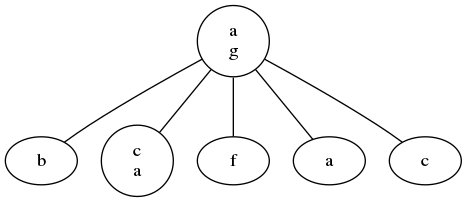

In [80]:
hlda=hierarchical_LDA(corpus2, alpha, beta, lambdas, eta, iters, level,num=5)
tree_plot(hlda,num=5)

*********level 0***********
  >>level 0 node 1: ['a', 'b', 'f', 'e']
 
*********level 1***********
  >>level 1 node 1 : ['e', 'a', 'c']
  >>level 1 node 2 : ['b']
 
Summary
Total level =  2
Topic number =  4
Each level contains nodes: [[1], [2]]


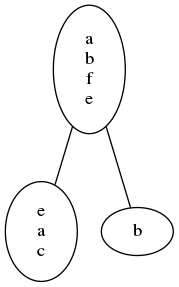

In [96]:
level=2
iters=100
hlda=hierarchical_LDA(corpus2, alpha, beta, lambdas, eta, iters, level,num=5)
tree_plot(hlda,num=5)

In [97]:
level=4
iters=100
hlda2=hierarchical_LDA(corpus1, alpha, beta, lambdas, eta, iters, level,num=5)

*********level 0***********
  >>level 0 node 1: ['in', 'of', 'and', 'the', 'with']
 
*********level 1***********
  >>level 1 node 1 : ['in', 'cost', 'piperaquine-resistant', 'Plasmodium', 'water']
  >>level 1 node 2 : ['the', 'in', 'and', 'to', 'a']
  >>level 1 node 3 : ['a', 'of', 'in', "['Phenotypic", '+']
 
*********level 2***********
  >>level 2 node 1 : ['resistance', 'and', 'respiratory', 'or', 'cells']
  >>level 2 node 2 : ['Squamous', 'on', "'Lentivirus-mediated", 'Absent', 'model']
  >>level 2 node 3 : ['Apoptosis', 'emergence', 'glioma', 'and', "cells.',"]
  >>level 2 node 4 : ['and', 'the', 'study', "subtypes.',", 'reproductive']
  >>level 2 node 5 : ['and', 'Plasmodium', 'Patients', 'Lateral-Flow', 'Polymorphisms']
  >>level 2 node 6 : ['of', 'parasite', 'Transcriptome', "Infection.',", 'as']
  >>level 2 node 7 : ['and', "Inflammation.',", 'opsonise', "['Free", "miRNAs.',"]
  >>level 2 node 8 : ["'Genome-wide", 'Anionic', 'for', 'Gene', 'A']
  >>level 2 node 9 : ['its', 'Su

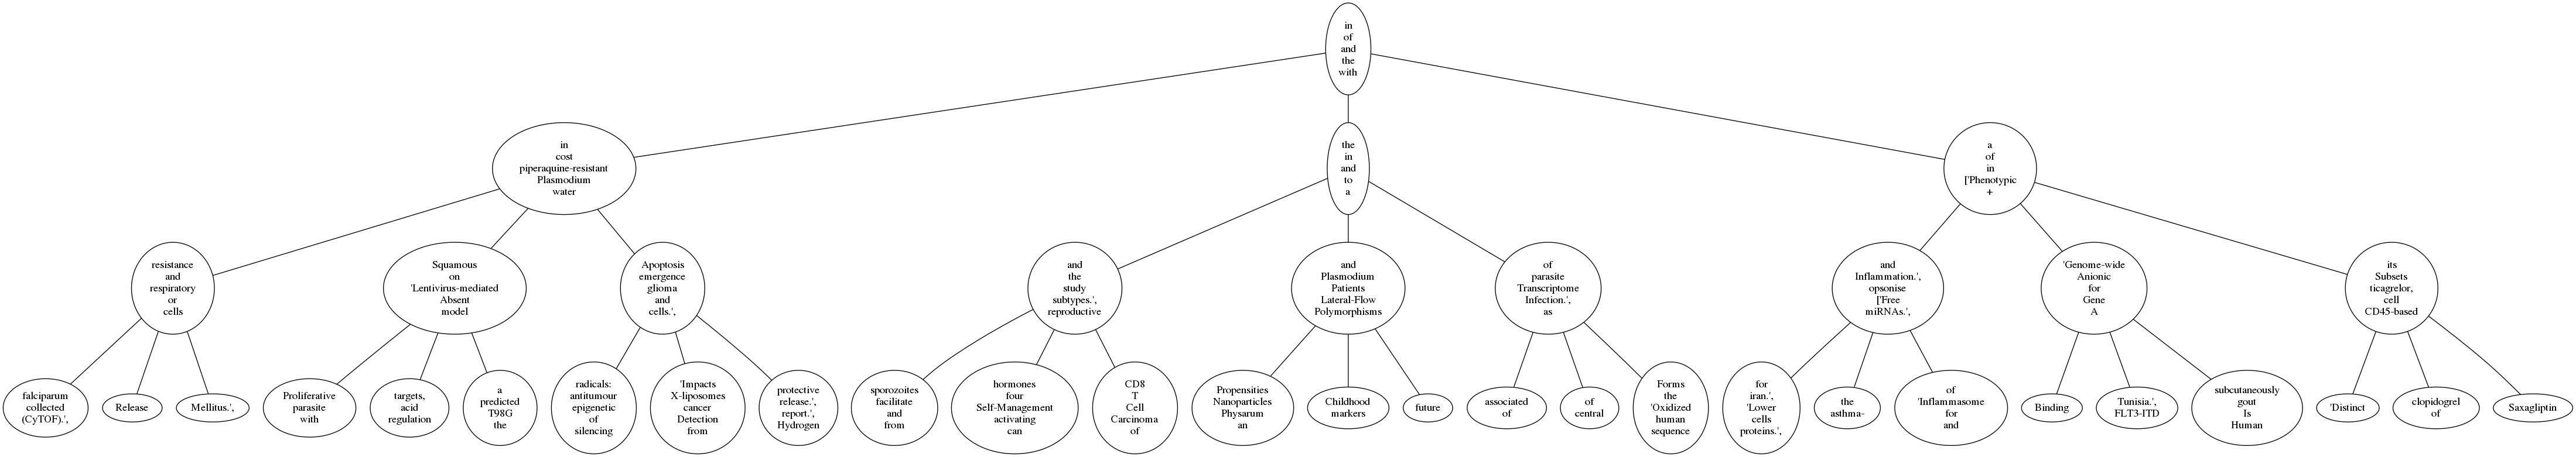

In [98]:
tree_plot(hlda2,num=5)

In [ ]:
Example 

In [ ]:
We generate a corpus of 100 1000 word documents from a three level hierarchy with a vocabulary of 25 items

In [46]:
import matplotlib.pyplot as plt

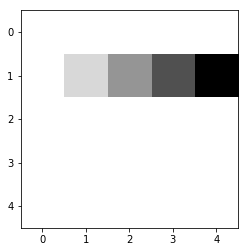

In [134]:
plt.imshow(a, interpolation='nearest',cmap='Greys')

In [129]:
a=np.zeros((5,5))
for j in list(np.random.choice([0,4],1)):
    for i in range(5):
        a[i,j]=int(np.random.choice(25,1))
for i in list(np.random.choice(5,2)):
    for j in range(5):
        a[i,j]=int(np.random.choice(25,1))

0
2


In [133]:
a=np.zeros((5,5))
a[1]=[1,1,2,3,5]

In [ ]:
word=i
    for level in range(3):
        k=np.random.choice([0,4],1)
        words.append(str(k)+'-'+i)

In [185]:
k1=int(np.random.choice([0,4],1))
n1=np.random.choice(list(range(1,6)),334)
words=[str(n1[i])+'-'+str(k1) for i in range(334)]
for level in range(2):
    k2=int(np.random.choice(5,1))
    n2=np.random.choice(list(range(1,6)),333)
    words.extend([str(k2)+'-'+str(n2[i]) for i in range(333)])

In [230]:
k1=int(np.random.choice([0,4],1))
n1=np.random.choice(5,334)
words=[str(n1[i])+'-'+str(k1) for i in range(334)]
w=words
k=np.random.choice(5,2,replace=False)
for level in range(2):
    k2=k[level]
    n2=np.random.choice(5,333)
    words.extend([str(k2)+'-'+str(n2[i]) for i in range(333)])
Counter(words)

[4 2]
4
2


Counter({'0-0': 73,
         '1-0': 63,
         '2-0': 132,
         '2-1': 66,
         '2-2': 72,
         '2-3': 73,
         '2-4': 53,
         '3-0': 68,
         '4-0': 131,
         '4-1': 67,
         '4-2': 63,
         '4-3': 68,
         '4-4': 71})

In [221]:
k2=(np.random.choice(5,2))
k2

array([2, 1])

In [231]:
def wordgene(i):
    np.random.seed(i)
    k1=int(np.random.choice([0,4],1))
    n1=np.random.choice(5,334)
    words=[str(n1[i])+'-'+str(k1) for i in range(334)]
    k=np.random.choice(5,2,replace=False)
    for level in range(2):
        k2=k[level]
        n2=np.random.choice(5,333)
        words.extend([str(k2)+'-'+str(n2[i]) for i in range(333)])
    return(words)

In [244]:
Counter(wordgene(1))

Counter({'0-4': 71,
         '1-0': 55,
         '1-1': 64,
         '1-2': 81,
         '1-3': 67,
         '1-4': 134,
         '2-4': 61,
         '3-0': 73,
         '3-1': 57,
         '3-2': 71,
         '3-3': 69,
         '3-4': 122,
         '4-4': 75})

In [256]:
corpus=[wordgene(i) for i in range(6)]

In [257]:
corpus_words=[word for doc in corpus for word in doc]

In [258]:
len(corpus),len(corpus_words)

(6, 6000)

In [259]:
Counter(corpus_words)

Counter({'0-0': 340,
         '0-1': 69,
         '0-2': 61,
         '0-3': 70,
         '0-4': 203,
         '1-0': 435,
         '1-1': 200,
         '1-2': 209,
         '1-3': 203,
         '1-4': 347,
         '2-0': 462,
         '2-1': 216,
         '2-2': 216,
         '2-3': 184,
         '2-4': 317,
         '3-0': 500,
         '3-1': 194,
         '3-2': 197,
         '3-3': 192,
         '3-4': 323,
         '4-0': 389,
         '4-1': 150,
         '4-2': 135,
         '4-3': 122,
         '4-4': 266})

In [260]:
temp=corpus[2]

In [261]:
Counter(temp)

Counter({'0-0': 60,
         '1-0': 129,
         '1-1': 66,
         '1-2': 70,
         '1-3': 66,
         '1-4': 65,
         '2-0': 145,
         '2-1': 71,
         '2-2': 75,
         '2-3': 56,
         '2-4': 64,
         '3-0': 76,
         '4-0': 57})

In [262]:
list(dict(Counter(temp)).values())[1]

76

In [263]:
mat

array([[138.,  64.,  62.,  76.,  64.],
       [ 63.,   0.,   0.,   0.,   0.],
       [ 69.,   0.,   0.,   0.,   0.],
       [122.,  62.,  65.,  77.,  74.],
       [ 64.,   0.,   0.,   0.,   0.]])

In [264]:
mat=np.zeros((5,5))
values=list(dict(Counter(temp)).values())
for k,position in enumerate(list(dict(Counter(temp)).keys())):
    i=int(position.split('-')[0])
    j=int(position.split('-')[1])
    mat[i,j]=values[k]

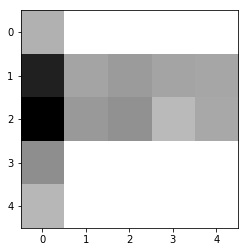

In [265]:
plt.imshow(mat, interpolation='nearest',cmap='Greys')

In [266]:
Counter(temp)

Counter({'0-0': 60,
         '1-0': 129,
         '1-1': 66,
         '1-2': 70,
         '1-3': 66,
         '1-4': 65,
         '2-0': 145,
         '2-1': 71,
         '2-2': 75,
         '2-3': 56,
         '2-4': 64,
         '3-0': 76,
         '4-0': 57})

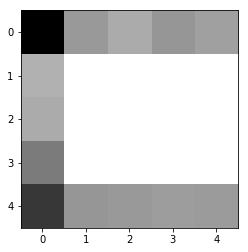

In [271]:
temp=corpus[0]
mat=np.zeros((5,5))
values=list(dict(Counter(temp)).values())
for k,position in enumerate(list(dict(Counter(temp)).keys())):
    i=int(position.split('-')[0])
    j=int(position.split('-')[1])
    mat[i,j]=values[k]
plt.imshow(mat, interpolation='nearest',cmap='Greys')

In [272]:
hierarchical_LDA(corpus, alpha, beta, lambdas, eta, iters=100, level=3,num=5,printing=1)

*********level 0***********
The 0 th iteration completed
The 1 th iteration completed
The 2 th iteration completed
The 3 th iteration completed
The 4 th iteration completed
The 5 th iteration completed
The 6 th iteration completed
The 7 th iteration completed
The 8 th iteration completed
The 9 th iteration completed
The 10 th iteration completed
The 11 th iteration completed
The 12 th iteration completed
The 13 th iteration completed
The 14 th iteration completed
The 15 th iteration completed
The 16 th iteration completed
The 17 th iteration completed
The 18 th iteration completed
The 19 th iteration completed
The 20 th iteration completed
The 21 th iteration completed
The 22 th iteration completed
The 23 th iteration completed
The 24 th iteration completed
The 25 th iteration completed
The 26 th iteration completed
The 27 th iteration completed
The 28 th iteration completed
The 29 th iteration completed
The 30 th iteration completed
The 31 th iteration completed
The 32 th iteration co

([[['0-0',
    '3-0',
    '3-0',
    '3-0',
    '1-0',
    '3-0',
    '2-0',
    '4-0',
    '0-0',
    '0-0',
    '4-0',
    '2-0',
    '1-0',
    '0-0',
    '1-0',
    '1-0',
    '0-0',
    '1-0',
    '4-0',
    '3-0',
    '0-0',
    '3-0',
    '0-0',
    '2-0',
    '3-0',
    '0-0',
    '1-0',
    '3-0',
    '3-0',
    '3-0',
    '0-0',
    '1-0',
    '1-0',
    '1-0',
    '0-0',
    '2-0',
    '4-0',
    '3-0',
    '3-0',
    '2-0',
    '4-0',
    '2-0',
    '0-0',
    '0-0',
    '4-0',
    '0-0',
    '4-0',
    '1-0',
    '4-0',
    '1-0',
    '2-0',
    '2-0',
    '0-0',
    '1-0',
    '1-0',
    '1-0',
    '1-0',
    '3-0',
    '3-0',
    '2-0',
    '3-0',
    '0-0',
    '3-0',
    '4-0',
    '1-0',
    '2-0',
    '4-0',
    '3-0',
    '4-0',
    '4-0',
    '4-0',
    '3-0',
    '4-0',
    '4-0',
    '4-0',
    '0-0',
    '4-0',
    '3-0',
    '2-0',
    '0-0',
    '1-0',
    '1-0',
    '3-0',
    '0-0',
    '0-0',
    '1-0',
    '2-0',
    '4-0',
    '2-0',
    '0-0',
    '3-0',

In [279]:
word = 'w%s' % int(round(num[j], 1)*10)
word

'w-8'

In [274]:
for i in range(3):
    n_cols = np.random.randint(10, 200, 1, dtype = 'int')[0]
    print(n_cols)
    for j in range(n_cols):
        num = np.random.normal(0, 1, n_cols)
        word = 'w%s' % int(round(num[j], 1)*10)
        print(word)
            #corpus[i].append(word)

166
w-19
w-13
w5
w20
w3
w-10
w15
w0
w2
w-13
w-9
w10
w-18
w12
w-13
w-14
w-11
w-14
w-9
w15
w-7
w10
w-21
w-7
w-18
w-5
w-10
w3
w-8
w3
w4
w-10
w3
w3
w-6
w9
w-1
w4
w-1
w-15
w6
w-14
w-2
w-2
w-3
w-6
w-16
w0
w17
w15
w-7
w-12
w-13
w4
w6
w9
w9
w-11
w6
w-2
w-22
w-20
w5
w-5
w-23
w-1
w4
w-7
w-17
w-23
w18
w-10
w-7
w11
w-7
w-10
w-4
w10
w17
w9
w-2
w-20
w7
w-16
w14
w-4
w0
w-9
w-2
w1
w-6
w-2
w9
w-22
w14
w-4
w3
w-30
w10
w6
w-2
w-8
w15
w12
w-5
w-12
w12
w-1
w5
w2
w4
w-19
w-12
w-15
w19
w-13
w-21
w-8
w10
w2
w-11
w-10
w11
w-2
w12
w12
w-3
w-10
w-12
w-7
w-13
w9
w-6
w-18
w-1
w-3
w12
w-5
w-12
w5
w-8
w14
w-11
w19
w9
w-25
w-2
w-3
w-5
w3
w16
w-8
w-3
w5
w9
w2
w-3
w15
w-1
w-4
w9
w6
w-14
w-24
w-11
w-6
82
w-8
w-1
w-1
w-14
w12
w-5
w6
w9
w-5
w21
w-6
w-5
w-2
w-4
w16
w5
w-1
w-3
w-3
w-2
w-4
w6
w7
w12
w4
w1
w-4
w-10
w-12
w23
w-2
w-10
w13
w7
w-7
w15
w-1
w2
w-8
w6
w2
w-18
w-9
w18
w-2
w-25
w-17
w-12
w17
w-6
w11
w0
w-15
w-1
w-11
w-7
w9
w7
w-1
w-5
w-2
w-8
w1
w-3
w-13
w8
w5
w-11
w-11
w0
w5
w9
w1
w6
w3
w-5
w0
w-16
w-2
w-2
w12
w5
37
w

In [81]:
file = open("ap.txt",'r') 
corpus0= []
for line in file:
    corpus0.append(line)

In [93]:
corpus0=corpus0[0:600]

In [94]:
corpus=[[] for i in range(100)]
corpus[0].append(corpus0[3])
for i in range(1,100):
    corpus[i].append(corpus0[3+6*i])

In [92]:
def read_data(corpus):
    import string
    n=len(corpus)
    new_corpus=[[] for i in range(n)]
    for i in range(n):
        temp=corpus[1][0].lower()
        temp=temp.translate(str.maketrans('', '', string.punctuation))
        temp=temp.replace('\n','').split(' ')
        temp=np.array(temp)
        temp=list(temp[temp!=''])
        new_corpus[i].extend(temp)
    return(new_corpus)

In [85]:
def vocabulary(corpus):
    word=[]
    for doc in corpus:
        for x in doc:
            word.extend(x)
    return(word)

In [95]:
corpus=read_data(corpus)

In [96]:
len(corpus)

100

In [97]:
corpus[1]

['the',
 'bechtel',
 'group',
 'inc',
 'offered',
 'in',
 '1985',
 'to',
 'sell',
 'oil',
 'to',
 'israel',
 'at',
 'a',
 'discount',
 'of',
 'at',
 'least',
 '650',
 'million',
 'for',
 '10',
 'years',
 'if',
 'it',
 'promised',
 'not',
 'to',
 'bomb',
 'a',
 'proposed',
 'iraqi',
 'pipeline',
 'a',
 'foreign',
 'ministry',
 'official',
 'said',
 'wednesday',
 'but',
 'thenprime',
 'minister',
 'shimon',
 'peres',
 'said',
 'the',
 'offer',
 'from',
 'bruce',
 'rappaport',
 'a',
 'partner',
 'in',
 'the',
 'san',
 'franciscobased',
 'construction',
 'and',
 'engineering',
 'company',
 'was',
 'unimportant',
 'the',
 'senior',
 'official',
 'told',
 'the',
 'associated',
 'press',
 'peres',
 'now',
 'foreign',
 'minister',
 'never',
 'discussed',
 'the',
 'offer',
 'with',
 'other',
 'government',
 'ministers',
 'said',
 'the',
 'official',
 'who',
 'spoke',
 'on',
 'condition',
 'of',
 'anonymity',
 'the',
 'comments',
 'marked',
 'the',
 'first',
 'time',
 'israel',
 'has',
 'acknowl

In [87]:
vocab_corpus=vocabulary(corpus)

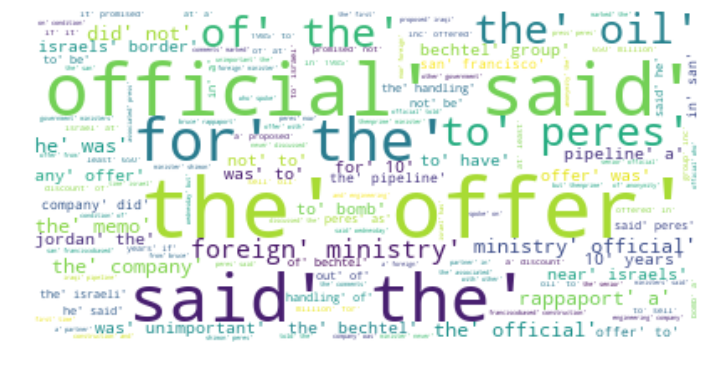

In [61]:
wordcloud = WordCloud(background_color='white').generate(str(vocab_corpus))
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [98]:
tree = hierarchical_LDA(corpus, 0.1, 0.01, 1, 0.01, 100, level=3,num=5)

*********level 0***********


KeyboardInterrupt: 

In [ ]:
0.1, 0.01, 1, 0.01, 100, 3

In [99]:
! pip install hlda

  Running setup.py bdist_wheel for hlda ... done
  Stored in directory: /home/jovyan/.cache/pip/wheels/c0/96/0d/79c6a4e965efa74c4541cc833dda92244d5477e4831a5f0f7e
Successfully built hlda
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [ ]:
## Optimization

In [102]:
import L

In [103]:
L.new(1)

i love you
1
